In [1]:
import torch
from torch import nn
import d2l.torch as d2l


模型 损失 优化
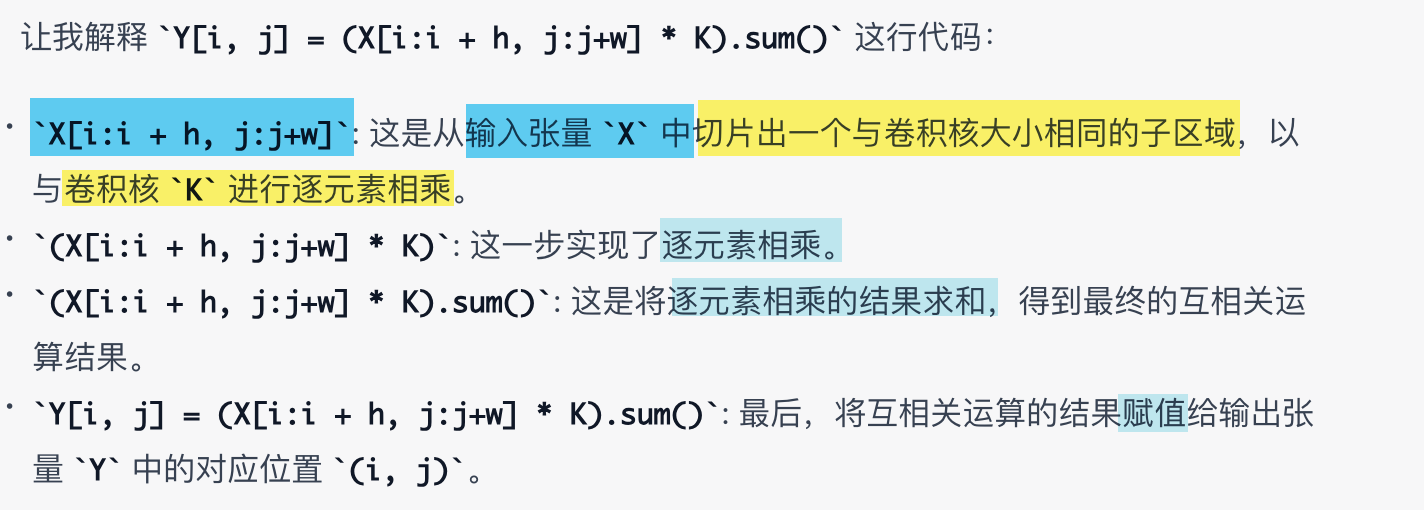

In [2]:
def corr2d(X,K):
    # 计算二维互相关运算
    h,w = K.shape
    Y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i + h,j:j+w]*K).sum()
    return Y

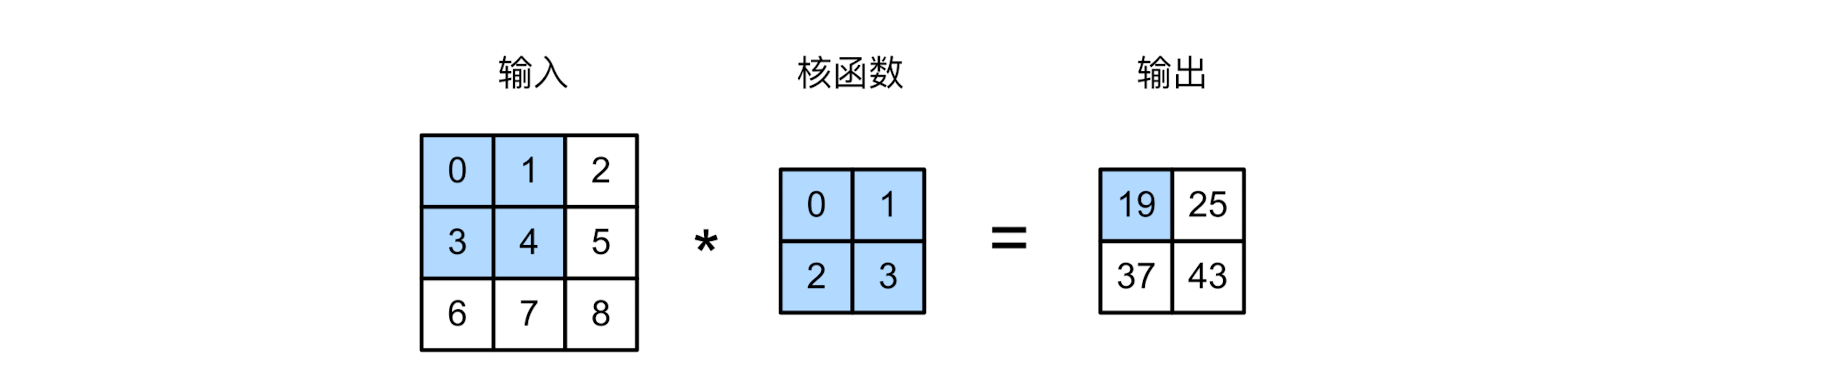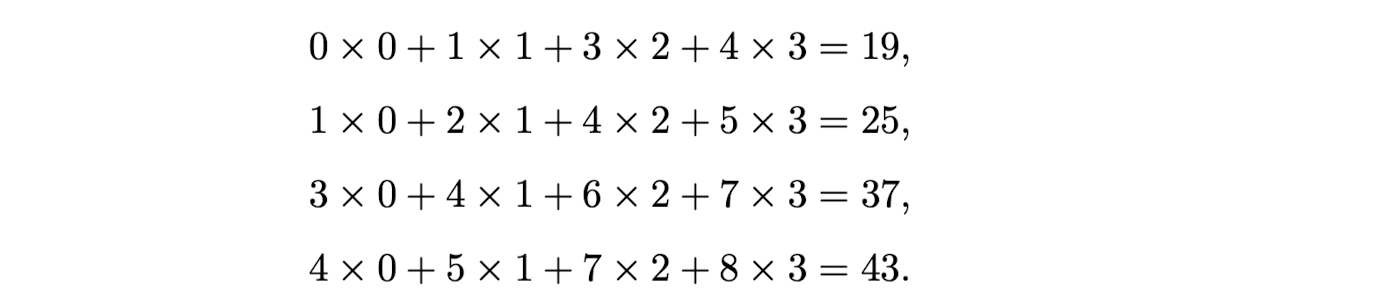

In [3]:
# 验证二维互相关运算的输出 输入张量X和卷积核张量K
X= torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self,x):
        return corr2d(x,self.weight) + self.bias

In [5]:
# 构造一个6×8的黑白像素，中间四列为黑色（0），其余像素为白色（1）
X = torch.ones((6,8))
X[:,2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
# 构造一个高度为1，宽度为2的卷积核K
# 进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零
K = torch.tensor([[1.0,-1.0]])

In [7]:
# 对输入X和卷积核K进行互相关运算
Y = corr2d(X,K)
Y
# 输出Y中的1表示从白色1到黑色0的边缘
# -1表示从黑色0到白色1的边缘
# 其他情况输出为0

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
# 如果将输入二维图像转置，再进行互相关运算，观察输出
corr2d(X.t(),K)
# 之前检测的垂直边缘消失了 说明卷积核K只检测垂直边缘，不检测水平边缘

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [9]:
print(f'X:{X},\n Y:{Y}')

X:tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]]),
 Y:tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


In [10]:
# 构造一个二维卷积层，只有1个输出通道和形状为（1,2）的卷积核
# 构造的方法：实例化nn.Conv2d
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias=False)
# 参数解释：输入通道 输出通道 卷积核大小 偏置

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度）
# 其中批量大小和通道数都为1
X = X.reshape((1,1,6,8))
# 卷积网络接受的输入 batch_size channels height width
Y = Y.reshape((1,1,6,7))
lr = 3e-2 #学习率 3*10^{-2}

for i in range(10): #迭代10次
    Y_hat = conv2d(X)
    l = (Y_hat - Y)**2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr*conv2d.weight.grad
    if (i+1)%2 == 0:
        print(f'epoch {i+1},loss {l.sum():.3f}')

epoch 2,loss 21.826
epoch 4,loss 7.815
epoch 6,loss 3.012
epoch 8,loss 1.202
epoch 10,loss 0.487


In [11]:
# 查看卷积核的权重张量
conv2d.weight.data

tensor([[[[ 0.9170, -1.0606]]]])

通过观察，学习到的卷积核权重非常接近我们之前定义的卷积核K

In [12]:
# 填充

# 定义一个卷积层函数
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d,X):
    X = X.reshape((1,1) + X.shape)
    # 这里的(1,1)表示批量大小和通道数都是1
    #  且第一个1是batch_size 第二个1是channel
    Y=conv2d(X)
    # 省略前两个维度：批量大小和通道数
    return Y.reshape(Y.shape[2:])
# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1)
X = torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [13]:
# 步幅
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [14]:
# 长和宽的步幅不一致的填充
# 填充增加输出图像的大小
# 步幅减少输出图像的大小
conv2d = nn.Conv2d(1,1,kernel_size=(3,5),padding=(0,1),stride=(3,4))
comp_conv2d(conv2d,X).shape

torch.Size([2, 2])

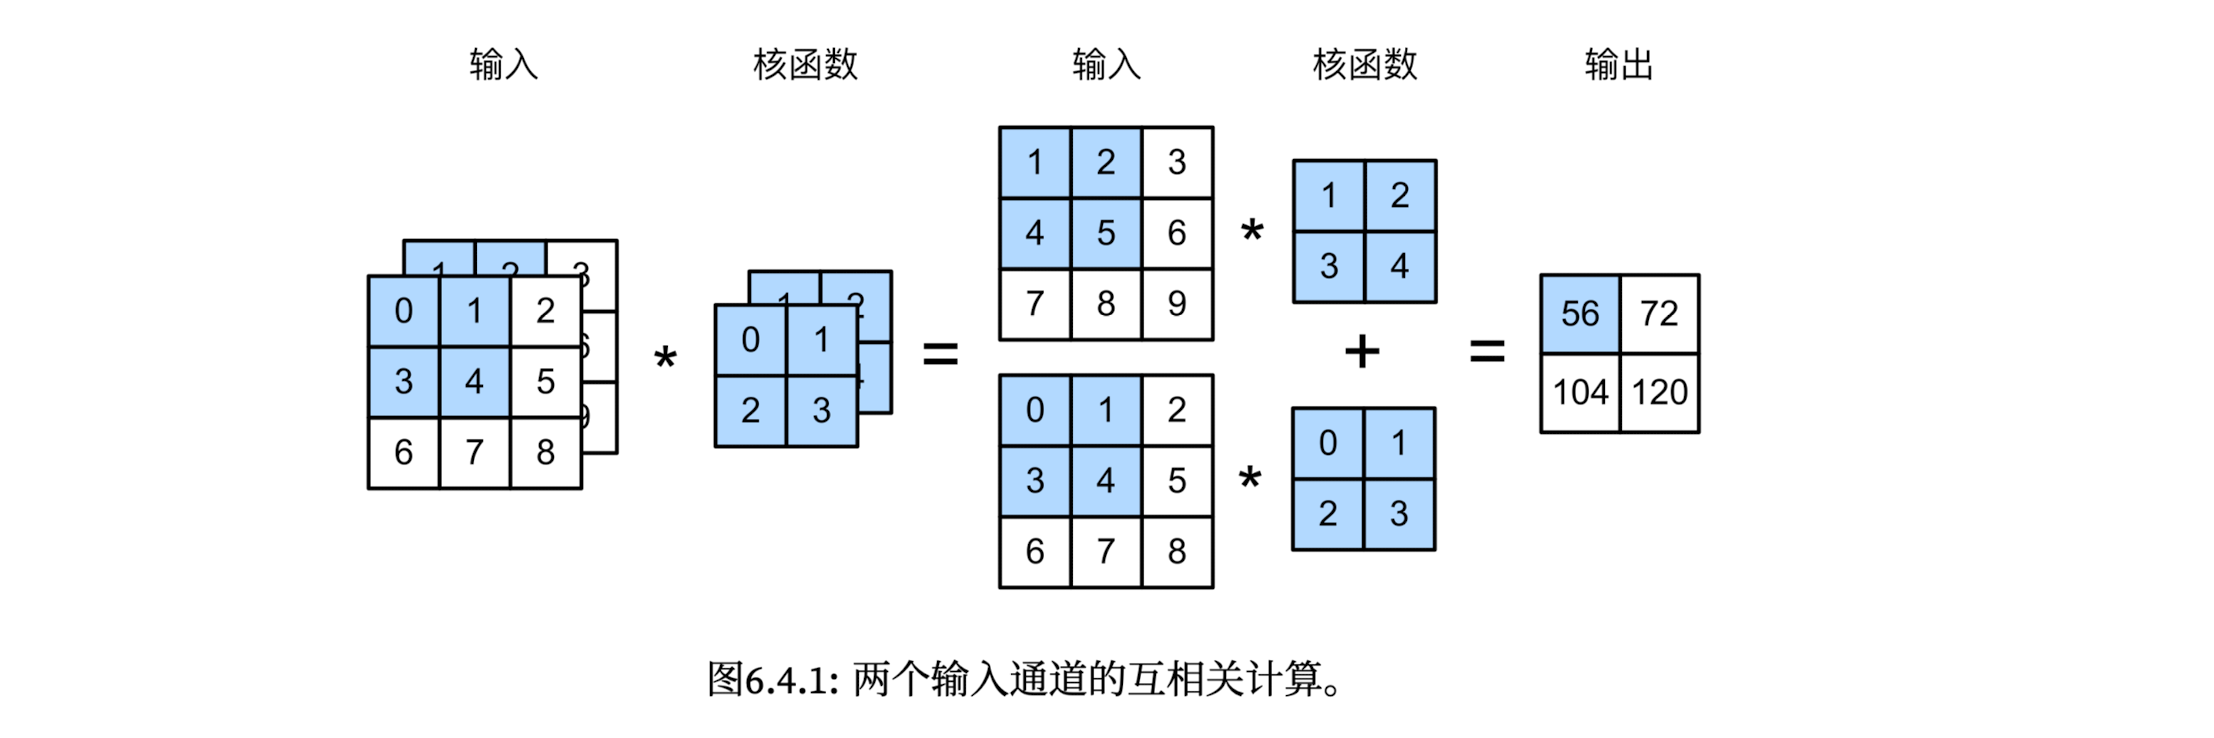
最后的相加？

多输入通道，单输出

In [15]:
def corr2d_multi_in(X,K):
    # 先遍历’X‘和’K‘的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x,k) for x,k in zip(X,K))

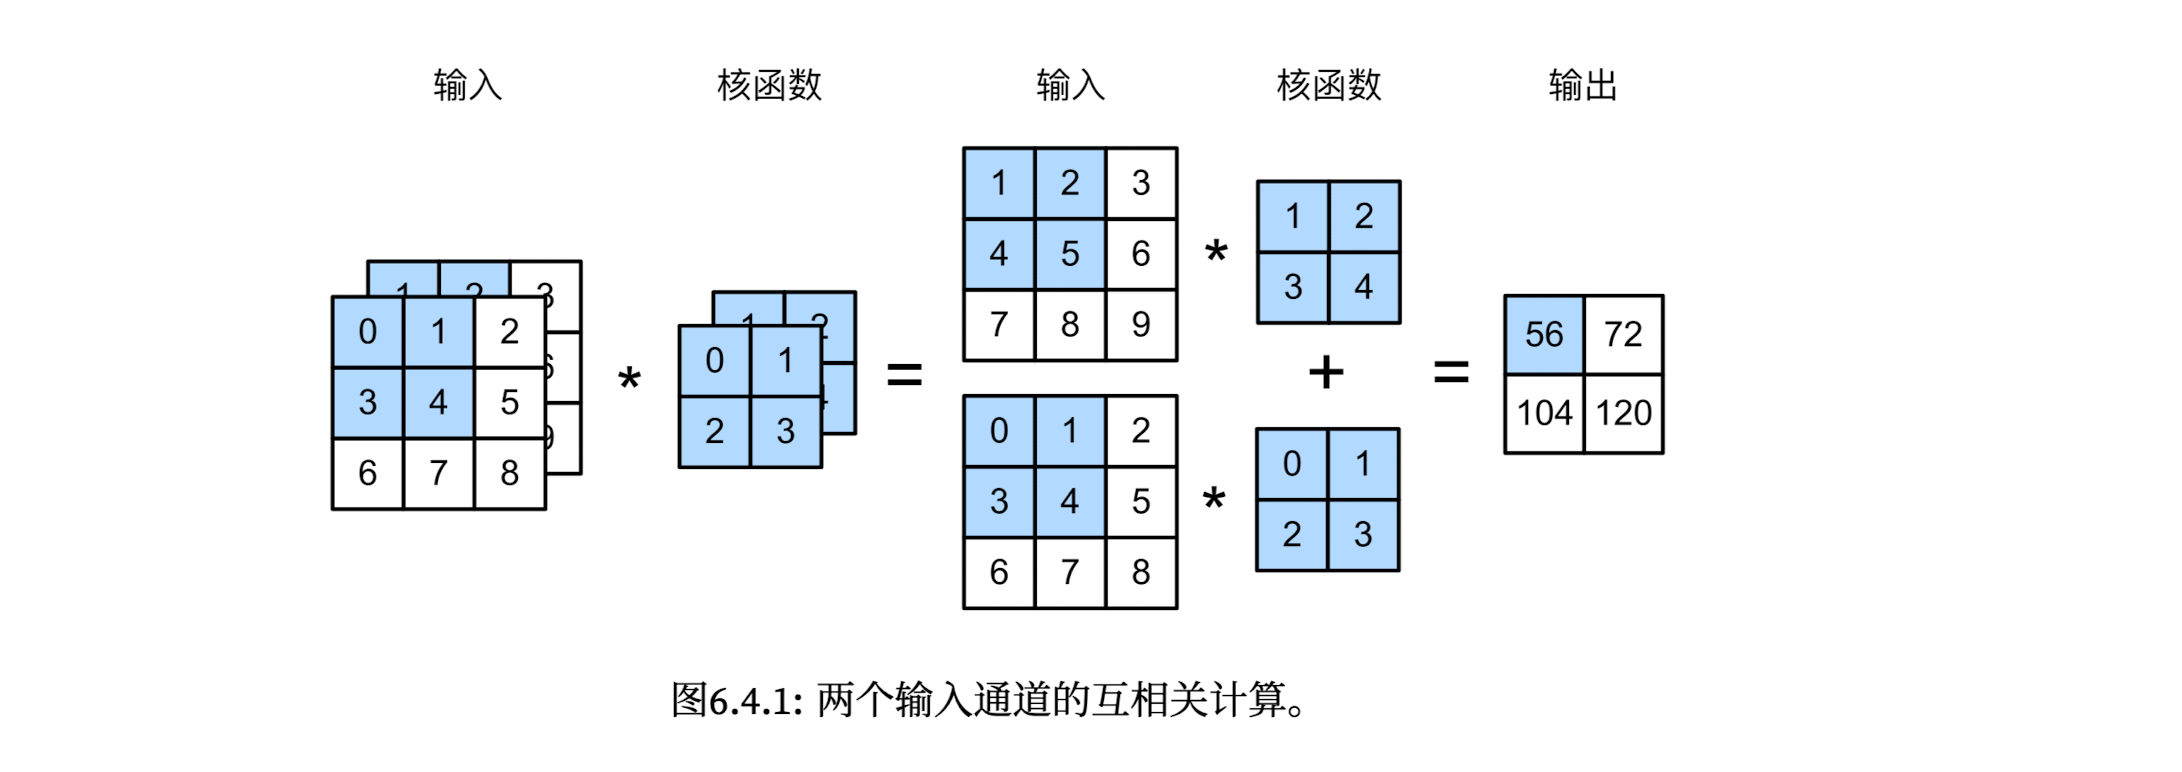

In [16]:
# X两通道
X = torch.tensor([
    [[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]],
    [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]]
])
K = torch.tensor([
    [[0.0,1.0],[2.0,3.0]],
    [[1.0,2.0],[3.0,4.0]]
])

corr2d_multi_in(X,K) #多输入通道

tensor([[ 56.,  72.],
        [104., 120.]])

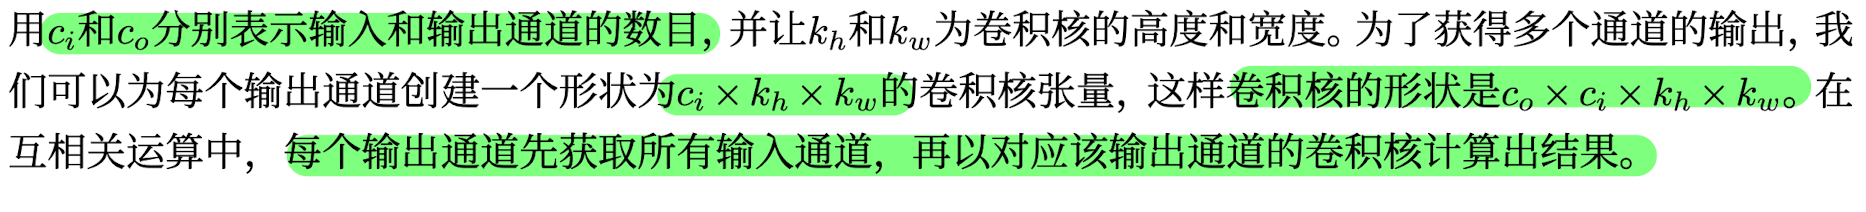

In [17]:
def corr2d_multi_in_out(X,K):
    # 迭代”K“的第0个维度，每次都对输入”X“执行互相关运算
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X,k) for k in K],0)

In [18]:
# 通过将核张量K与K+1（K中每个元素加1）和K+2连接起来，构造了一个具有3个输出通道的卷积核
K = torch.stack((K,K+1,K+2),0)
K.shape,K

(torch.Size([3, 2, 2, 2]),
 tensor([[[[0., 1.],
           [2., 3.]],
 
          [[1., 2.],
           [3., 4.]]],
 
 
         [[[1., 2.],
           [3., 4.]],
 
          [[2., 3.],
           [4., 5.]]],
 
 
         [[[2., 3.],
           [4., 5.]],
 
          [[3., 4.],
           [5., 6.]]]]))

In [19]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [20]:
# 1*1 卷积
def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w = X.shape #c_i = c_input
    c_o = K.shape[0]  #获取卷积核张量K的第一个维度大小，即输出通道数。
    X = X.reshape((c_i,h*w)) #将输入张量X重塑为一个形状为(c_i, h*w)的二维张量，其中每一列代表一个输入样本。
    K = K.reshape((c_o,c_i)) #卷积核张量K重塑为一个形状为(c_o, c_i)的二维张量，其中每一行代表一个输出通道的卷积核。
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K,X) #使用矩阵乘法计算卷积操作，将重塑后的输入张量X与重塑后的卷积核张量K相乘，得到输出特征图。
    return Y.reshape((c_o,h,w)) #将输出特征图重塑为形状为(c_o, h, w)，并返回作为结果。

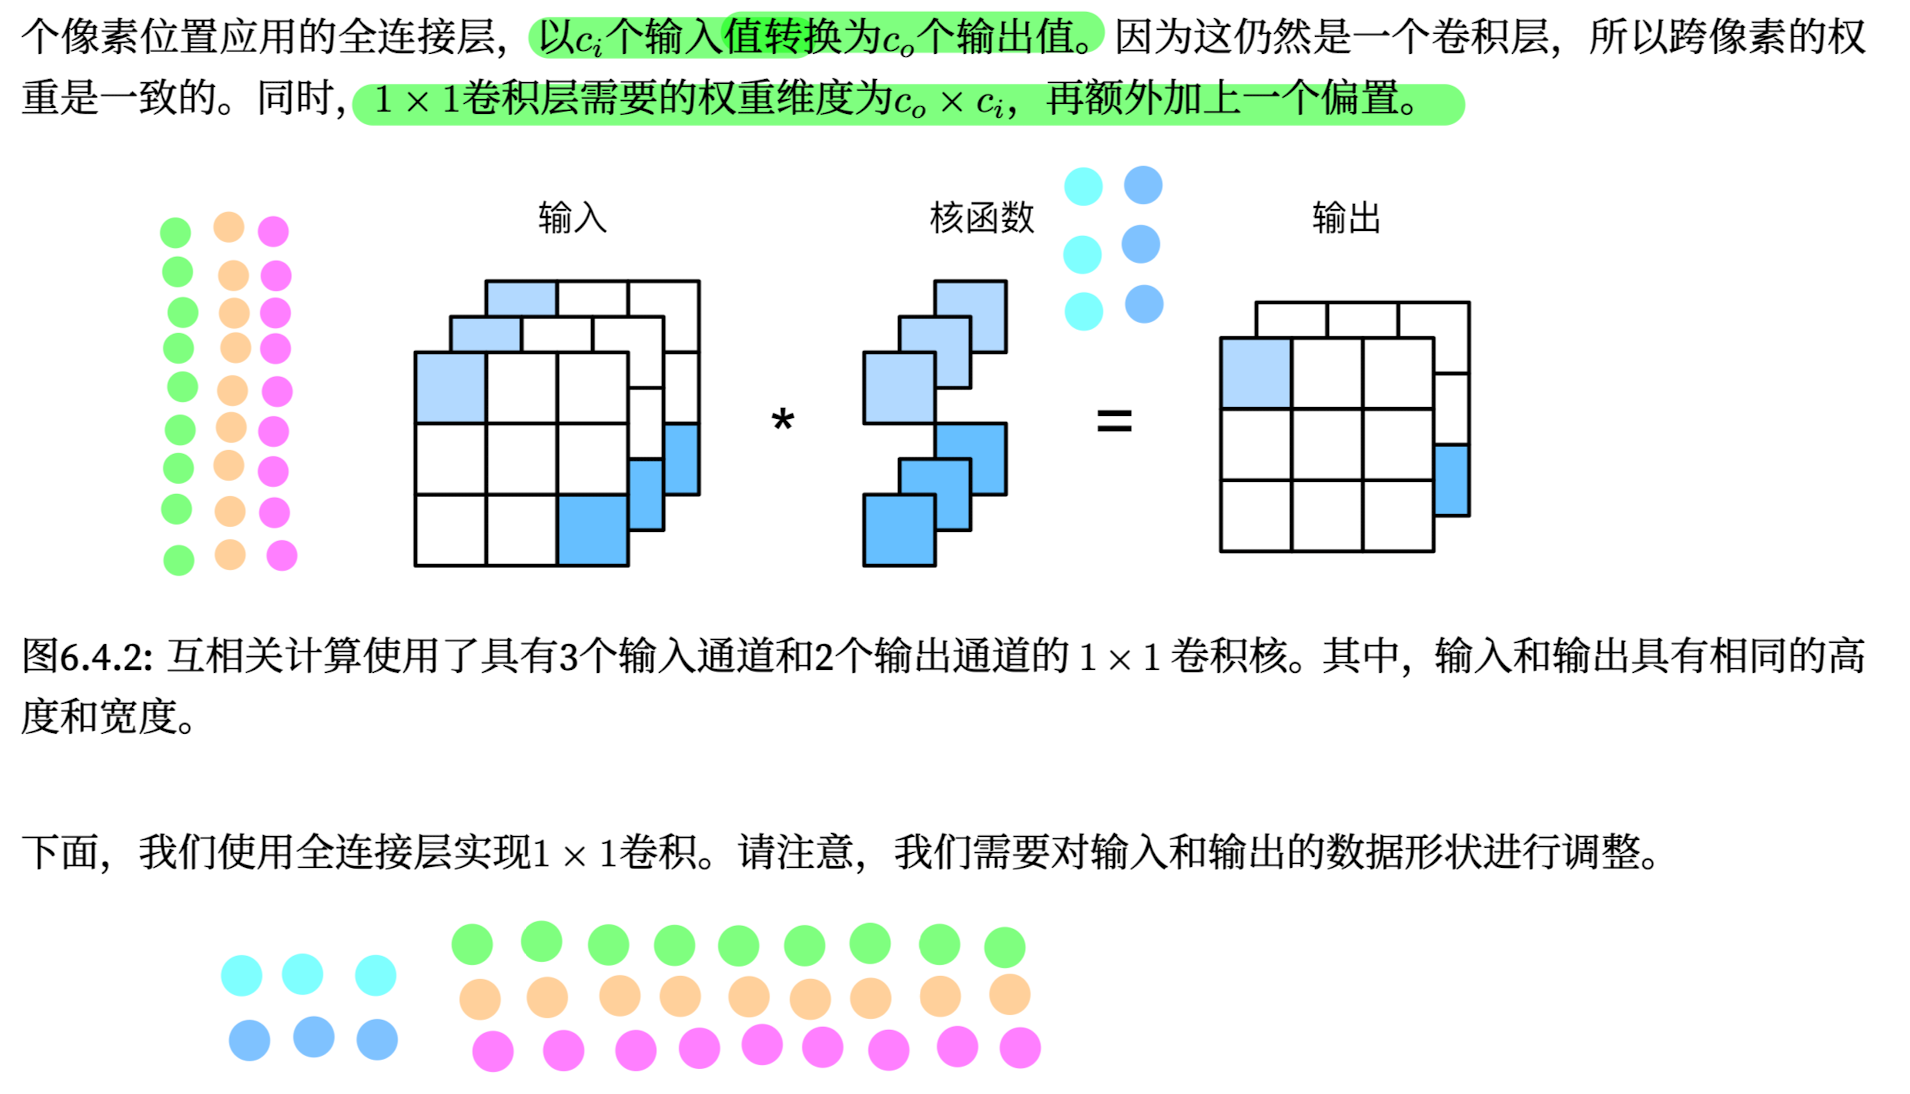

In [21]:
X = torch.normal(0,1,(3,3,3)) 
#创建一个形状为(3, 3, 3)的张量X，其中每个元素都是从均值为0、标准差为1的正态分布中随机采样得到的。
K = torch.normal(0,1,(2,3,1,1))
#创建一个形状为(2 out-channels, 3 in-channels, 1, 1)的张量K，其中每个元素也是从均值为0、标准差为1的正态分布中随机采样得到的。
# 这个张量可以看做是一个卷积核，其中第一个维度表示输出通道数，第二个维度表示输入通道数，
# 后面两个维度则表示卷积核的高度和宽度。
# 在这里，由于卷积核是一个1x1大小的卷积核，所以高度和宽度都是1。

In [22]:
Y1 = corr2d_multi_in_out_1x1(X,K)
Y2 = corr2d_multi_in_out(X,K)
assert float(torch.abs(Y1-Y2).sum()) < 1e-6

AssertionError: 

- pooling层 ：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性
- pooling 汇聚层
- 卷积涉及概念表示：卷积核、特征映射、感受野、填充、步幅、pooling
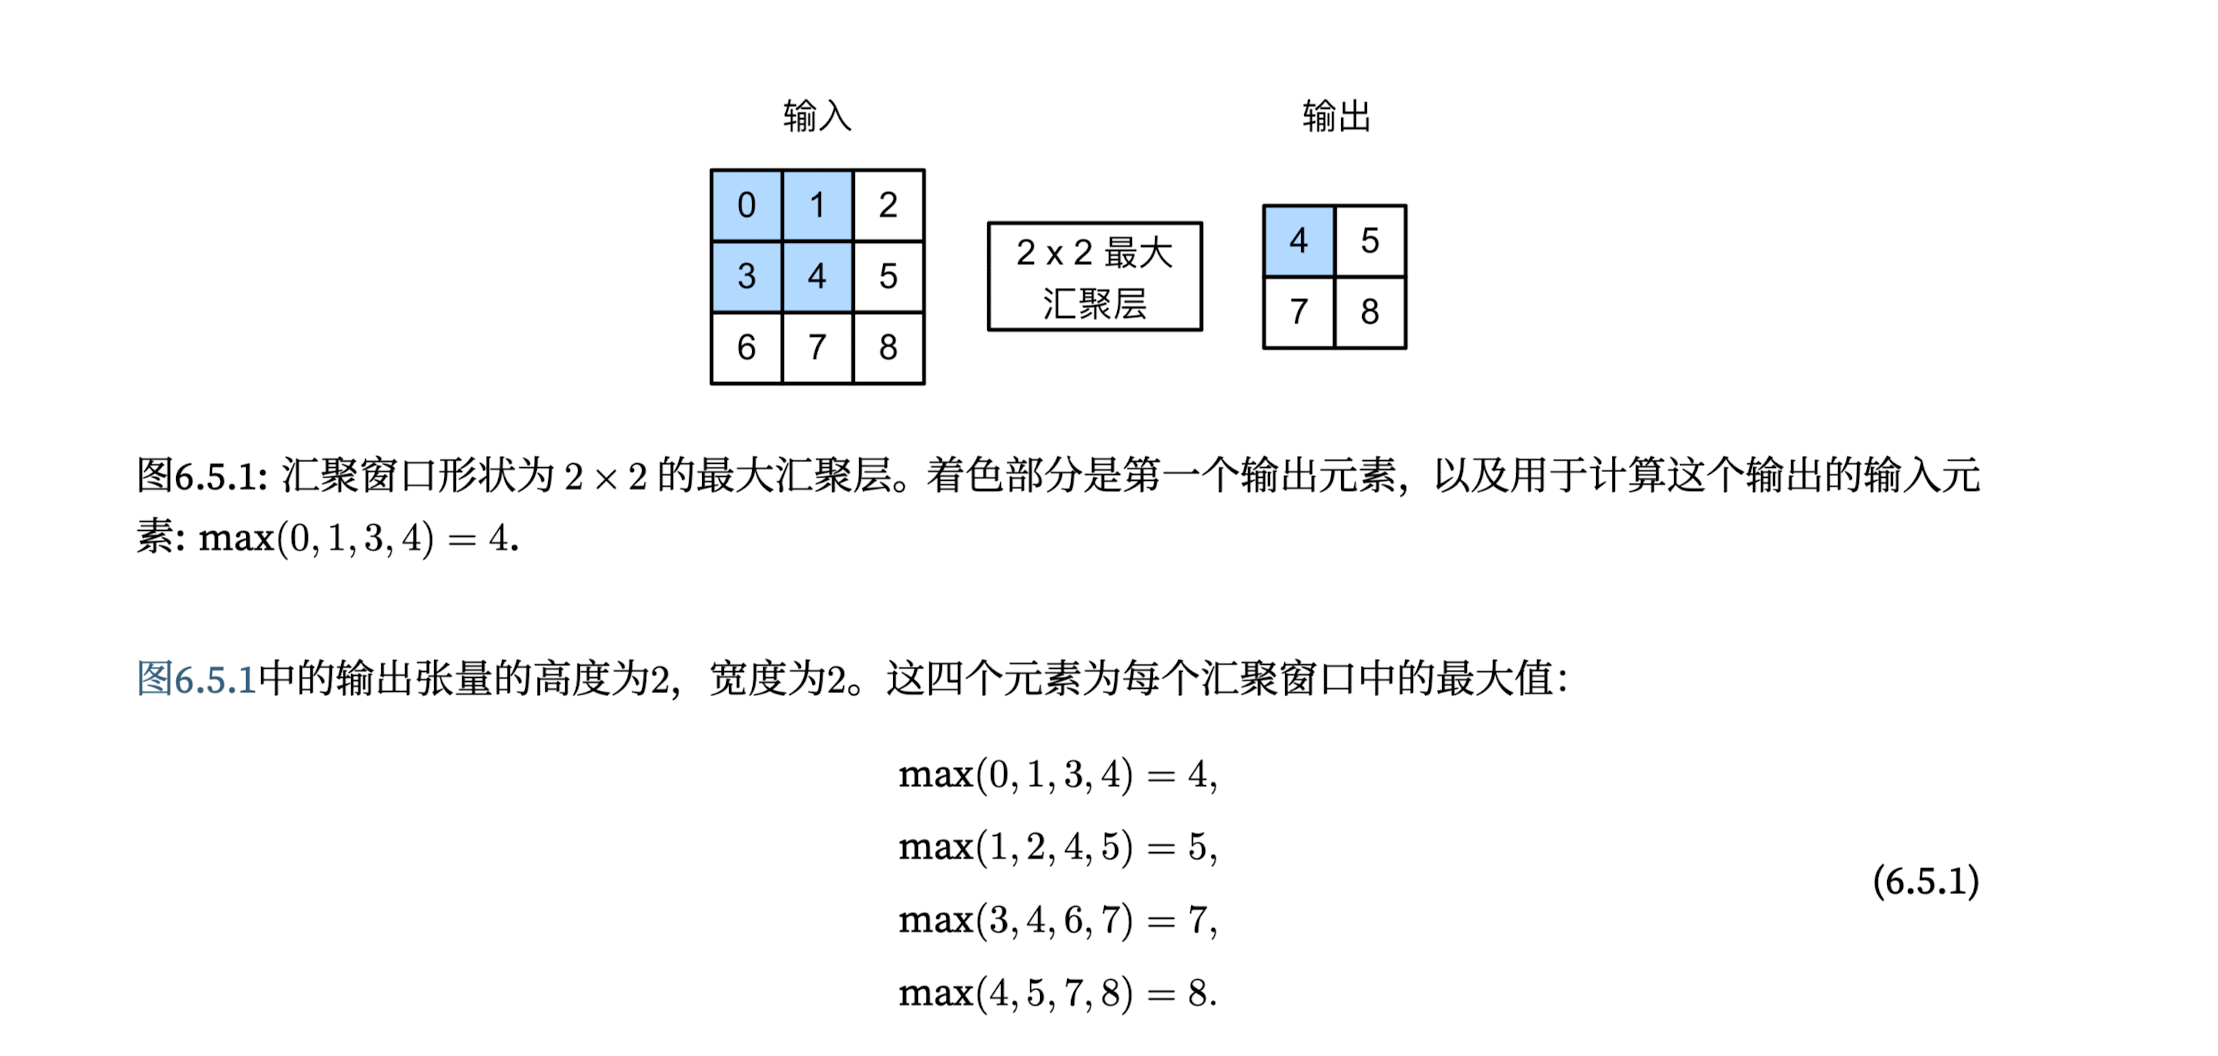

In [23]:
def pool2d(X,pool_size,mode='max'):
    p_h,p_w = pool_size
    Y = torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1)) #?
    '''
        在池化操作中，输出特征图的大小通常会缩小
        X.shape[0] - p_h + 1 跟卷积操作很像
        表示在垂直方向上可以进行的池化窗口的数量，
        X.shape[1] - p_w + 1
        表示在水平方向上可以进行的池化窗口的数量。
        所以，通过这个表达式计算得到的形状(X.shape[0]-p_h+1, X.shape[1]-p_w+1)
        可以保证输出特征图的尺寸与池化窗口对应。   
    '''
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i,j] = X[i:i + p_h,j:j+p_w].max()
            elif mode == 'avg':
                Y[i,j] = X[i:i+p_h,j:j+p_w].mean()
    return Y


In [24]:
# 默认最大池化层
X = torch.tensor([i for i in range(9)]).reshape(3,3).float()
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

In [25]:
# 平均池化层
pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

In [26]:
# 池化层中的填充和步幅
# 样本1个 通道数1 
X = torch.arange(16,dtype=torch.float32).reshape((1,1,4,4)) 
#1 个样本、1 个通道、高度为 4、宽度为 4 的特征图
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [27]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [28]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2) #填充和步幅可以指定
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [29]:
# 设定一个任意大小的矩形汇聚窗口 并分别设定填充和步幅的高度和宽度
pool2d = nn.MaxPool2d((2,3),stride=(2,3),padding=(0,1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [30]:
# 多通道pooling
X = torch.cat((X,X+1),1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [31]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# LeNet
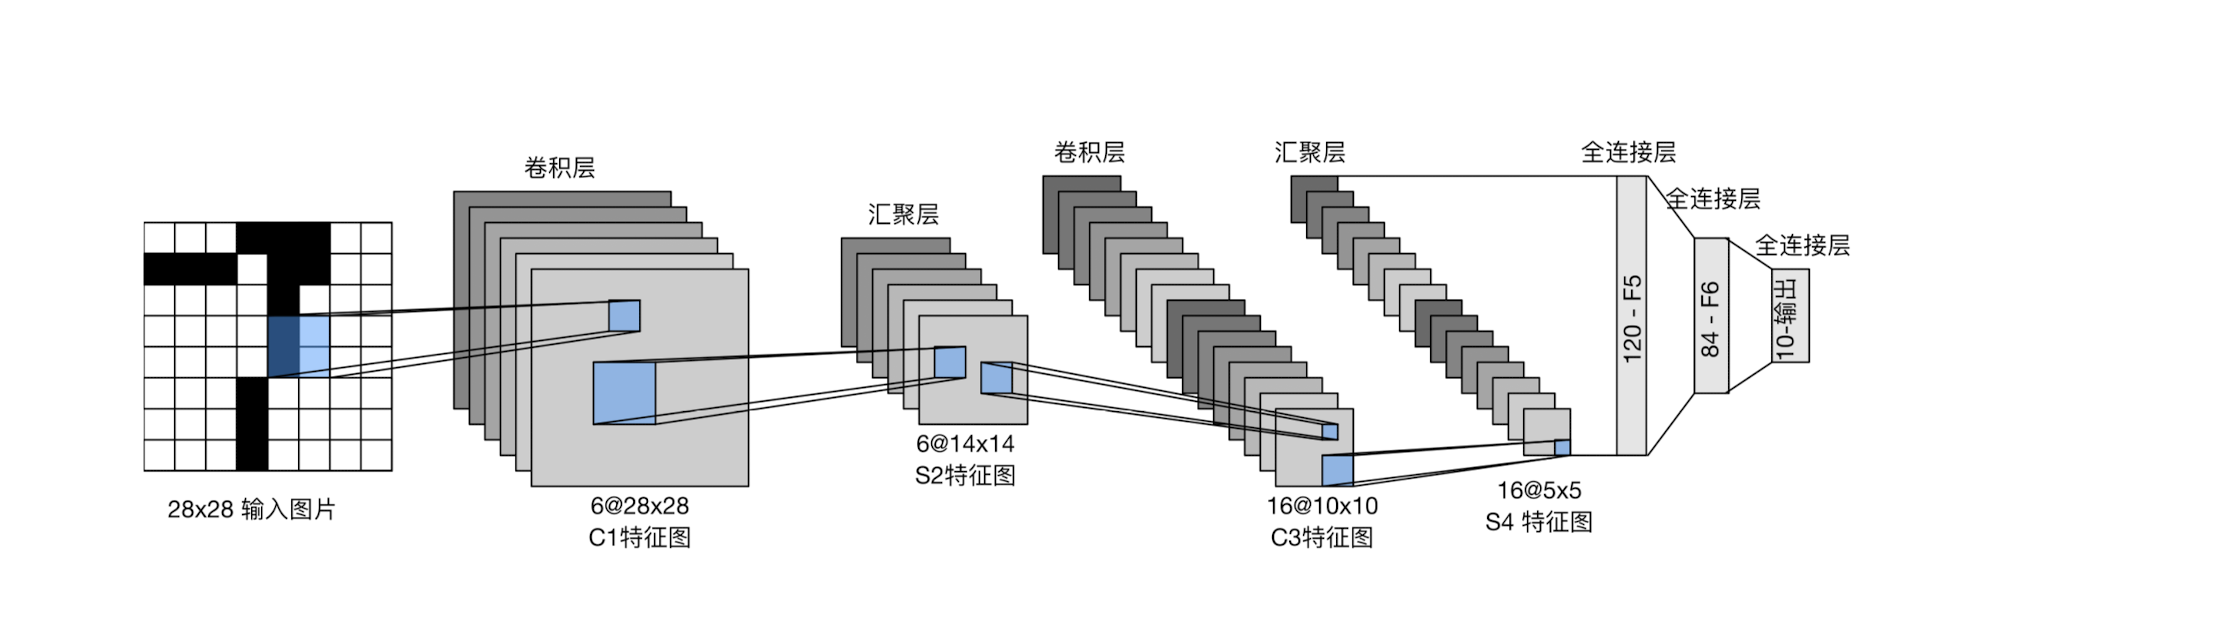
6@28\*28 6层输出通道 每个输出通道的尺寸是28*28

In [33]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [34]:
X= torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [35]:
# LeNet与Fashion-MNIST数据集
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [37]:
# GPU加速
def evaluate_accuracy_gpu(net,data_iter,device=None):
    # 定义了一个名为evaluate_accuracy的函数，
    # 该函数接受三个参数：net表示模型，data_iter表示数据迭代器，device表示设备（默认为None）。
    # 使用GPU计算模型在数据集上的精度
    if isinstance(net,nn.Module):
    # 判断net是否是nn.Module的实例，即判断net是否是一个PyTorch模型。
        net.eval()  #设置为评估模型
        # 将模型设置为评估模式。
        # 在评估模式下，模型中的一些特定层（例如Dropout）可能会被禁用或修改，
        # 以保证在评估过程中的一致性和效果。
        if not device:
            device = next(iter(net.parameters())).device
            # 如果没有指定设备，则将设备设置为模型参数中的第一个参数所在的设备。
            # 即将模型移动到与参数张量存储位置相同的设备上。
    # 正确预测的数量，总预测数量
    metric = d2l.Accumulator(2) #函数内部的实现看不太懂 函数功能最终实现的东西也不明白
    # 创建一个名为metric的累加器对象，用于记录正确预测的数量和总预测数量。
    # 该累加器的初始化参数2表示需要记录两个值。
    with torch.no_grad():
    # 在评估过程中，关闭梯度计算，以减少内存消耗和加速计算。
        for X,y in data_iter:
            # 遍历数据迭代器，获取输入数据X和标签数据y
            if isinstance(X,list):
                # BERT微调所需的（之后介绍
                X= [x.to(device) for x in X]
                # 如果输入数据X是一个列表（例如BERT微调所需的多个输入），
                # 则将列表中的每个元素都移动到指定设备上。
            else:
                X = X.to(device)
                # 如果输入数据X不是一个列表，则将其移动到指定设备上。
            y = y.to(device)
            # 将标签数据y移动到指定设备上。
            metric.add(d2l.accuracy(net(X),y),y.numel()) #numel数元素
            # 使用模型对输入数据X进行前向传播得到预测结果，然后计算预测准确率，
            # 并将准确率和标签数量添加到累加器metric中。
    return metric[0]/metric[1]
# 计算并返回预测准确率，即正确预测的数量除以总预测数量。

In [42]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    # net：神经网络模型
    # train_iter：训练数据迭代器，用于训练模型
    # test_iter：测试数据迭代器，用于评估模型性能
    # num_epochs：训练的总轮数
    # lr：学习率，用于优化算法
    # device：设备，可以是CPU或GPU，用于训练模型
    
    # 用GPU训练模型
    def init_weights(m):
        if type(m) == nn.Linear or type(m)==nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    # 这是一个权重初始化函数init_weights，
    # 它会对神经网络模型中的线性层（nn.Linear）和卷积层（nn.Conv2d）的权重进行 Xavier 初始化，
    # 以帮助模型更快地收敛。
    net.apply(init_weights)
    # 这一行代码应用了上面定义的权重初始化函数，将其应用到传入的神经网络模型net的所有权重。
    print('traning on',device)
    # 这行代码输出正在使用的设备，是CPU还是GPU。
    net.to(device)
    # 这行代码将神经网络模型移动到指定的设备（CPU或GPU），以确保在该设备上进行训练。
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    # 这行代码定义了一个随机梯度下降（SGD）优化器，它用于更新神经网络的参数，学习率为lr
    loss = nn.CrossEntropyLoss()
    # 这行代码定义了损失函数，通常用于分类任务的损失函数，即交叉熵损失。
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                            legend=['train loss','train acc','test acc'])
    # 这行代码创建了一个动画图表，用于可视化训练过程中的损失和准确率
    timer,num_batches = d2l.Timer(),len(train_iter)
    # 这行代码创建了一个计时器，用于计算训练每个批次的时间，以及获取训练数据迭代器的批次数量。
    for epoch in range(num_epochs):
        # 训练损失之和 训练准确率之和 样本数
        metric = d2l.Accumulator(3)
        # 这行代码创建了一个累加器metric，用于累积训练过程中的损失、训练准确率和样本数量。
        net.train()
        # 这行代码将神经网络模型切换到训练模式，以启用训练相关的操作，如梯度计算和参数更新。
        for i,(X,y) in enumerate(train_iter):
            # 内嵌的循环，用于遍历训练数据集中的所有批次，并进行模型训练。
            timer.start()
            # 内嵌循环，遍历训练数据集中的每个批次，X是输入数据，y是标签。
            # 启动计时器，用于计算每个批次的训练时间。
            optimizer.zero_grad()
            # 将优化器的梯度缓存清零，以准备计算新的梯度。
            X,y = X.to(device),y.to(device)
            # 将输入数据和标签移动到指定的设备（CPU或GPU）上。
            y_hat = net(X)
            # 通过前向传播计算模型的预测结果y_hat。
            l = loss(y_hat,y)
            # 计算预测结果和真实标签之间的损失。
            l.backward()
            # 执行反向传播，计算梯度并存储在模型的参数中。
            optimizer.step()
            # 执行优化步骤，更新模型的参数以减小损失。
            with torch.no_grad():
                metric.add(l*X.shape[0],d2l.accuracy(y_hat,y),X.shape[0])
                # 使用累加器metric来累积损失、准确率和样本数量。
            timer.stop()
            # 停止计时器，记录每个批次的训练时间。
            train_l = metric[0] / metric[2]
            train_acc = metric[1]/metric[2]
            # 计算当前训练过程的平均损失和平均准确率。
            if (i+1)%(num_batches // 5) == 0 or i==num_batches-1:
                animator.add(epoch + (i+1) / num_batches,
                             (train_l,train_acc,None))
            # 用于更新动画图表，将当前的训练损失和准确率添加到图表中。
        test_acc = d2l.evaluate_accuracy_gpu(net,test_iter)
        # 使用测试数据集来评估模型的
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss {train_l:.3f},train acc {train_acc:.3f},'
          'test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs / timer.sum():.1f } examples/sec'
          f' on {str(device)}')


loss 0.475,train acc 0.822,test acc {test_acc:.3f}


ValueError: Invalid format specifier

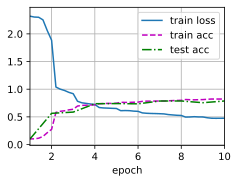

In [43]:
lr,num_epochs = 0.9,10
train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

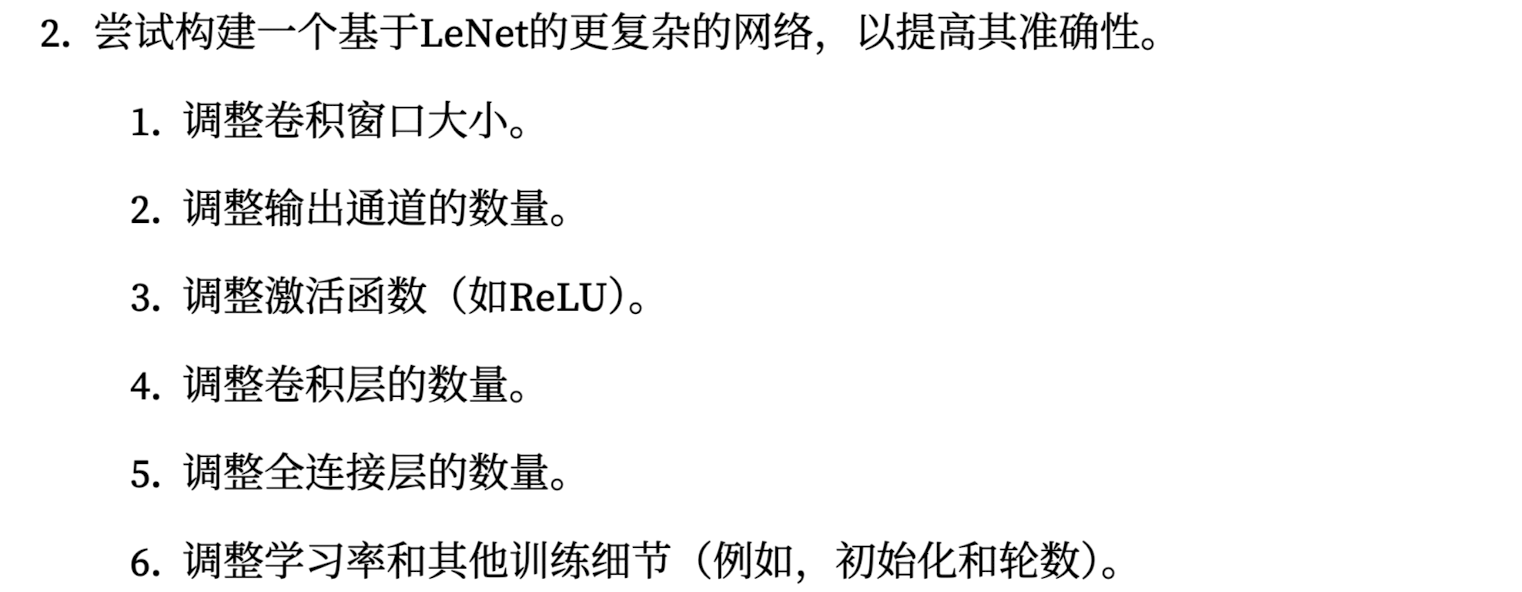